# Assignment 3

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:

    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import keras_tuner as kt
from keras_tuner import HyperParameters

2025-06-01 18:17:13.180118: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 18:17:13.186791: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 18:17:13.250139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-01 18:17:13.250190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-01 18:17:13.251937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

This lab continues our study of linear regression. You'll train your first models with Tensorflow, using a real dataset to predict car prices from their features. Note that Tensorflow is a rapidly changing library. This means you'll often see warnings about deprecations. You can ignore the warnings in our labs.

---
### Step 1: Data ingestion

You'll use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets).

This dataset has been pre-downloaded and uploaded to bCourses alongside this notebook for your convenience.

In [2]:
car_data_init = pd.read_csv("automobile_data.txt")

# Display top five rows
print('Shape of data:', car_data_init.shape)
car_data_init.head()

Shape of data: (205, 26)


,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,symboling
0,NaN,alfa-romero,gas,std,2.0,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,3
1,NaN,alfa-romero,gas,std,2.0,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,3
2,NaN,alfa-romero,gas,std,2.0,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,1
3,164.0,audi,gas,std,4.0,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,2
4,164.0,audi,gas,std,4.0,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,2


---
### Step 2: Data preprocessing

This step is essential for preparing the data in a format that is suitable for ML algorithms. It helps ensure data quality and improvements in model performance.

### <span style="color:chocolate">Exercise 1:</span> Column selection (5 points)

To keep things simple, you will:

1. Retain only the following columns: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']. Name the new dataframe *car_data*.
2. Display the data type of each column;
3. Convert the data type of each columns to numeric. Coerce missing values to NaN. Hint: use <span style="color:chocolate">pd.to_numeric()</span> method;
4. Display the data type of each column after the transformation performed at point 3.


In [3]:
# YOUR CODE HERE

#retaining and displaying
cols = ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
car_data = car_data_init[cols].copy()
print(car_data.dtypes)

#converting to numeric

car_data[cols] = car_data[cols].apply(pd.to_numeric, errors='coerce')

print(car_data.dtypes)

horsepower     float64
peak-rpm       float64
city-mpg         int64
highway-mpg      int64
price          float64
dtype: object
horsepower     float64
peak-rpm       float64
city-mpg         int64
highway-mpg      int64
price          float64
dtype: object


### <span style="color:chocolate">Exercise 2:</span> Example (row) selection (5 points)

To keep things simple again, you will:

1. Print the shape of the car_data;

2. Remove examples (rows) that have missing value(s). Note that in doing so, you will overwrite the car_data dataset. You should end up with 199 examples after this cleaning.

3. Print the shape of the car_data again.

It's important to acknowledge that there are multiple approaches to handling missing features, and simply discarding examples with any missing feature, though straightforward, may not be the most optimal solution. However, for the sake of simplicity, you will implement this strategy in this assignment.

In [4]:
# YOUR CODE HERE

print(car_data.shape)
car_data = car_data.dropna()
print(car_data.shape)

(205, 5)
(199, 5)


### <span style="color:chocolate">Exercise 3:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. Note that the original data (above) appears sorted by *make* in alphabetic order.

Using NumPy and Pandas methods:

1. Create a list of indices corresponding to the rows in the car_data dataset. Call this list *indices*. Print this list;

2. Shuffle *indices* using the <span style="color:chocolate">np.random.permutation()</span> method. Call the resulting array *shuffled_indices*. Print this array;
    
3. Use the method <span style="color:chocolate">dataframe.reindex()</span> to change the ordering of the car_data dataset based on the order in the *shuffled_indices* array. Note that in doing so, you will overwrite the original dataset. Print the top 5 rows.

In [5]:
np.random.seed(0)
# YOUR CODE HERE

#creating indexes
indices = car_data.index.to_list()
print(indices)

#shuffling
shuffled_indices = np.random.permutation(indices)
print(shuffled_indices)

#reindexing
car_data = car_data.reindex(shuffled_indices)
print(car_data.head())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204]
[ 19 175 109  95 182 189   5 145  13 166  64 127 170 151  83   7  34 135
  38  77 165 150  48 164  63 125 184 

### <span style="color:chocolate">Exercise 4:</span> Define outcome and features (5 points)

Create two dataframes as follows:

1. The first dataframe contains our outcome of interest: ['price']. Note, this is what we are aiming to predict. Name this dataframe Y. Print shape of Y.
2. The second dataframe contains our features of interest: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']. Name this dataframe X. Print shape of X.


### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

In [22]:
# YOUR CODE HERE

#creating dataframes
Y = car_data[['price']]
x_cols = ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']
X = car_data[x_cols]

print(Y.shape, X.shape)

(199, 1) (199, 4)


Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Partition the (X, Y) data into training, validation, and test sets using a splitting rule of [60%, 20%, 20%], with a random state set to 1234. Name the resulting dataframes as follows: X_train, X_val, X_test, Y_train, Y_val, Y_test. Hint: To create these three partitions you will utilize the train_test_split() method twice (all the other arguments of the method are set to default values.). You should obtain [119, 40, 40] examples for training, validation, and test, respectively.
2. Print the shape of each dataframe.

Note: The validation set is crucial for evaluating different hyperparameter configurations and selecting those that yield optimal model performance. This approach avoids utilizing the test dataset during model training, as it is assumed to be "unknown" at that stage.

In [1]:
# YOUR CODE HERE

X_temp, X_test, Y_temp, Y_test = train_test_split(X,Y, test_size=0.2, random_state=1234, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp,Y_temp, test_size=0.25, random_state=1234, shuffle=True)

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

NameError: name 'train_test_split' is not defined

### <span style="color:chocolate">Exercise 6:</span> Data standardization (10 points)

With this concept in mind, complete the following tasks:

1. Output the quantile values (0.25, 0.5, 0.75, 0.95) for all features in the X_train dataset. Are these values uniformly scaled across features?

2. Standardize all features in X_train, X_val, and X_test. Label the resulting dataframes as X_train_std, X_val_std, and X_test_std, respectively. Hint: standardize the validation and test data using the mean and standard deviation computed from the training data. Why?

3. Similar to point 2. but now standardize the outcome variable. Label the resulting dataframes as Y_train_std, Y_val_std, and Y_test_std.

In [8]:
# YOUR CODE HERE

# quantiles
quantiles = X_train.quantile([0.25, 0.50, 0.75, 0.95])
print(quantiles)

uniform_scaling = quantiles.max() - quantiles.min()
print(uniform_scaling)

#mean and std
mu_X  = X_train.mean()
sig_X = X_train.std(ddof=0) 

X_train_std = (X_train - mu_X) / sig_X
X_val_std   = (X_val   - mu_X) / sig_X
X_test_std  = (X_test  - mu_X) / sig_X

#standardizing target value
mu_y  = Y_train.mean()
sig_y = Y_train.std(ddof=0)

Y_train_std = (Y_train - mu_y) / sig_y
Y_val_std   = (Y_val   - mu_y) / sig_y
Y_test_std  = (Y_test  - mu_y) / sig_y

#results

print(mu_X, sig_X, X_train_std, X_val_std, X_test_std, mu_y, sig_y, Y_train_std, Y_val_std, Y_test_std)

'''Values differ, due to features are not uniformly scaled'''

      horsepower  peak-rpm  city-mpg  highway-mpg
0.25        69.0    4800.0      21.0         25.0
0.50        90.0    5100.0      25.0         30.0
0.75       116.0    5400.0      31.0         37.0
0.95       176.6    5810.0      37.0         42.1
horsepower      107.6
peak-rpm       1010.0
city-mpg         16.0
highway-mpg      17.1
dtype: float64
horsepower      100.092437
peak-rpm       5084.873950
city-mpg         25.739496
highway-mpg      31.352941
dtype: float64 horsepower      37.186107
peak-rpm       451.400930
city-mpg         6.339767
highway-mpg      6.758236
dtype: float64      horsepower  peak-rpm  city-mpg  highway-mpg
97    -0.836130  0.255042  0.829763     0.835582
154   -1.024373 -0.631089  0.198825     0.095744
63    -0.970589 -0.963387  1.618436     1.575420
161   -0.809239 -0.631089  0.356560     0.391679
140   -0.728563 -1.517219  0.041091    -0.052224
..          ...       ...       ...          ...
80     0.427782  0.919639 -0.432113    -0.200191
151   -1.0243

---
### Step 3: Exploratory data analysis (EDA)

EDA plays a very important role in ML. The goal here is to develop a good understanding of our training dataset, identify any data quality issues, understand patterns and relationships, which in turn, aids in subsequent modeling and interpretations.

### <span style="color:chocolate">Exercise 7:</span> Scatterplot matrix (10 points)

In this exercise you will use some simple yet useful techniques to visualize the distribution of the data. 

Let's start with:

1. A scatterplot matrix to visualize the pair-wise correlations between different features and outcome in the (X_train_std, Y_train_std) data. You will use the <span style="color:chocolate">sns.pairplot()</span> method from the seaborn library imported at the top of the notebook;
2. Is any of the variables in the data normally distributed? Is it necessary for the explanatory or target variable to be normally distributed in order to train a ML model?

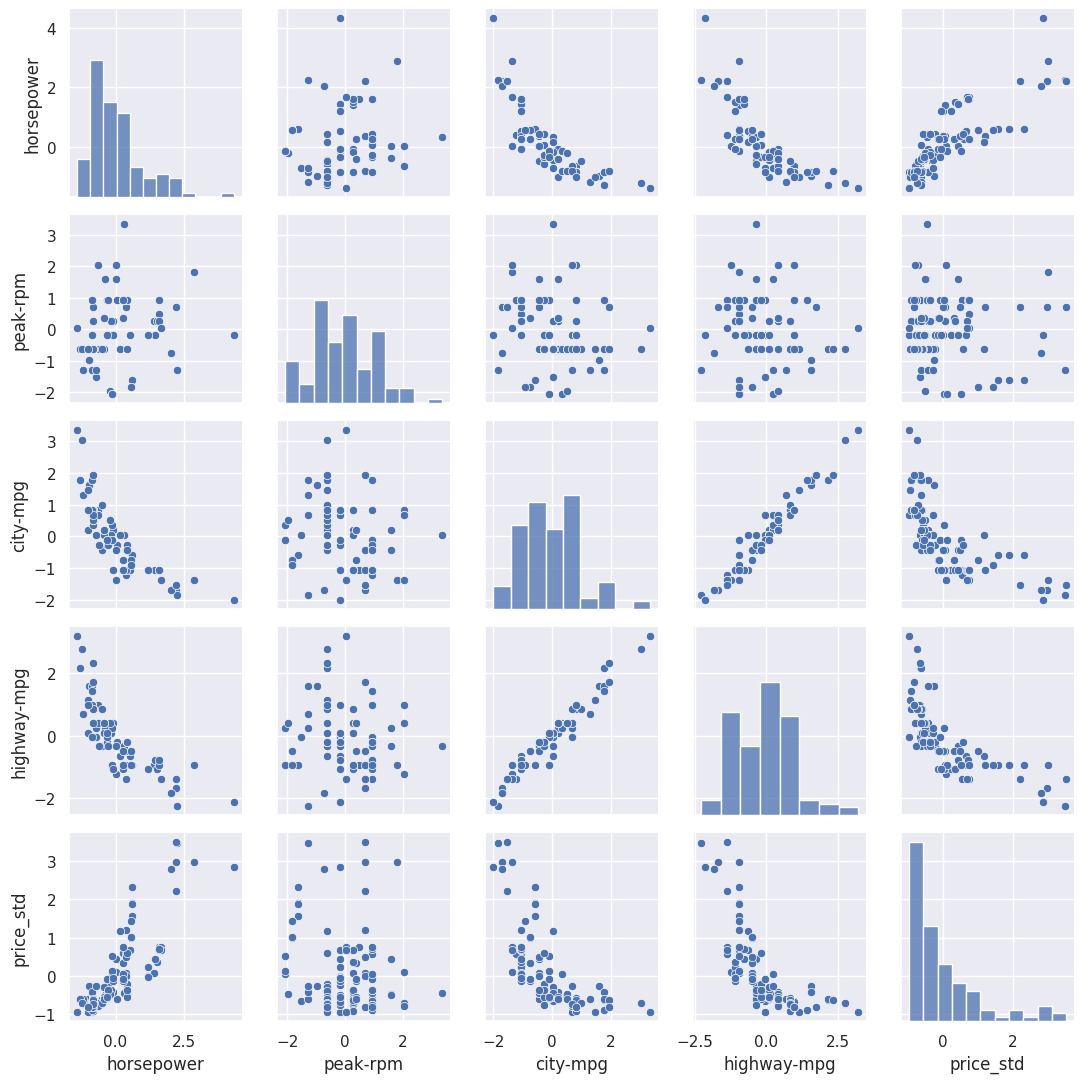

In [10]:
# YOUR CODE HERE

train_std = X_train_std.copy()
train_std['price_std'] = Y_train_std

#plotting
sns.pairplot(train_std, diag_kind="hist", height=2.2)
plt.tight_layout()
plt.show()

'''horse power is slightly normal distributed with a right skew thought'''
'''highway-mpg is slightly normal distributed'''

### <span style="color:chocolate">Exercise 8:</span> Correlation matrix (10 points)

In this exercise you will:

1. Plot a correlation matrix in the form of a heatmap to visualize the linear relationships between different features and outcome in the (X_train_std, Y_train_std) data. Hint: this example here is very useful: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
2. Answer the following questions: 
 - Which two features are likely to be most redundant?
 - Which feature is likely to be least useful for predicting price?

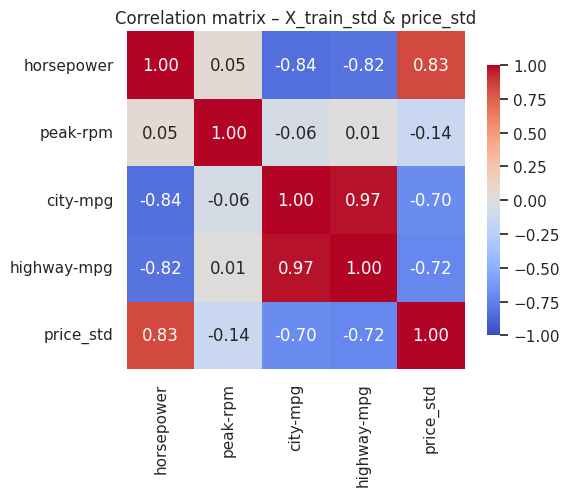

'the least useful feature is horsepower'

In [11]:
# YOUR CODE HERE

#feature set and target
train_std = X_train_std.copy()
train_std['price_std'] = Y_train_std

#correlation
corr = train_std.corr()

#plotting
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, fmt=".2f", cbar_kws={"shrink": .8})
plt.title("Correlation matrix – X_train_std & price_std")
plt.tight_layout()
plt.show()

'''the most redundant features and city-mpg and highway-mpg due to higher correlation'''
'''the least useful feature is peak-rpm'''

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 9:</span> Baseline model (5 points)

Let's start by evaluating a baseline model. Precisely, you'll use the average price of cars in the training set as our baseline model -- that is, the baseline always predicts the average price regardless of the input.

1. Implement this baseline using the Y_train_std data and print the average price. Note: You can revert the price variable to the original scale for interpretation purposes.

In [12]:
# YOUR CODE HERE

baseline_pred_1 = Y_train_std.mean()

#scalling back to original scale
baseline_pred_orig = baseline_pred_1 * sig_y + mu_y

print(baseline_pred_1, baseline_pred_orig)

4.664802624475448e-17 12889.008403361344


### <span style="color:chocolate">Exercise 10:</span> Improvement over Baseline with TensorFlow (10 points)

Let's train a linear regression model much like we did in the previous assignment, but this time using TensorFlow. 

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: refer to the course webpage in <span style="color:chocolate">bCourses/Modules/Module Demos/03 Features.ipynb</span> for an example.
2. Build and compile a model using the build_model() function and the (X_train_std, Y_train_std) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_std, Y_train_std) data. Set num_epochs = 5. Pass the (X_val_std, Y_val_std) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model) method.
3. Generate a plot with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the [tf.keras.Model.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model) method returns.

More notes on point 1: the idea is to build a *computational graph* for linear regression, and then send data through it. There are many ways to build graphs, but [TenforFlow Keras API](https://www.tensorflow.org/api_docs/python/tf/keras) is recommended. 

In [15]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      input_shape=1,  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.keras.initializers.Ones(),  # initialize params to 1
      bias_initializer=tf.keras.initializers.Ones(),    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use GD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. This finalizes the graph for training.
  # We specify the MSE loss and the optimizer above
  model.compile(optimizer=optimizer, loss='mse')
    
  return model

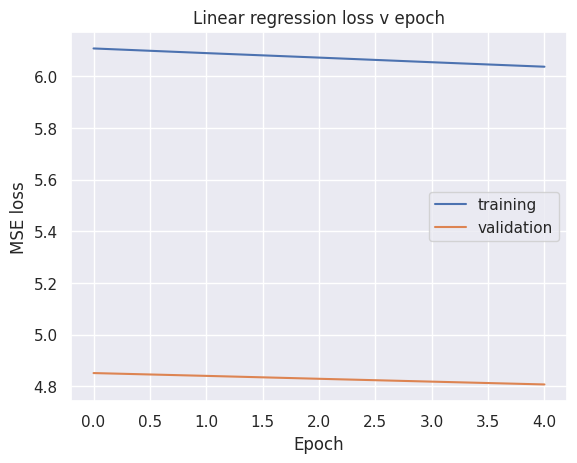

In [16]:
tf.random.set_seed(0)
# 2. Build and compile model
# YOUR CODE HERE

model_tf = build_model(num_features=X_train_std.shape[1], learning_rate=1e-4)

# 3. Fit the model
# YOUR CODE HERE

history = model_tf.fit(X_train_std, Y_train_std, epochs=5, validation_data=(X_val_std, Y_val_std), verbose=0)

#plotting
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Linear regression loss v epoch')
plt.legend()
plt.show()

---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as learning rate, number of epochs, and optimizer to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 11:</span> Hyperparameter tuning (10 points)

1. Fine-tune the **learning rate** and **number of epochs** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). If you decide to work with the Keras Tuner, define a new model building function named <span style="color:chocolate">build_model_tuner()</span>.

After identifying your preferred model configuration, print the following information:

2. The learned parameters of the tuned model (this should include the bias term). Hint: use  <span style="color:chocolate">[model_name].layers[0].get_weights()</span>.
3. The loss at the final epoch on both the training and validation datasets;
4. The difference between the last-epoch loss observed on the training and validation datasets.


Please note that we will consider 'optimal model configuration' any last-epoch training loss that is below 0.31 and any last epoch validation loss that is below 0.48. Hint: do not specify the batch_size argument in the fit() function (it defaults to 32).

In [2]:
tf.random.set_seed(0)
# YOUR CODE HERE

model_tf = build_model(num_features=X_train_std.shape[1], learning_rate=0.01)

history = model_tf.fit(X_train_std, Y_train_std, epochs=300, validation_data=(X_val_std, Y_val_std), verbose=0)

w, b = model_tf.layers[0].get_weights()

print(w.flatten())
print(b[0])

NameError: name 'tf' is not defined

---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized (tuned) model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 12:</span> Computing MSE (10 points)

1. Calculate the MSE on both (X_train_std, Y_train_std) and (X_test_std, Y_test_std) datasets. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your observations. Hint: compare train vs. test MSE.

4. Generate a plot to visualize the accuracy of the predictions. Plot the actual (observed) Y_test values on the x-axis and the predicted Y_test values on the y-axis. Additionally, include a 45-degree line in the plot for reference. Ensure that the plot contains appropriate axis labels and a title. Provide commentary on the model's fit based on this visualization. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras. 

6.025982856750488
6.407589912414551
2/2 [==============================] - 0s 3ms/step


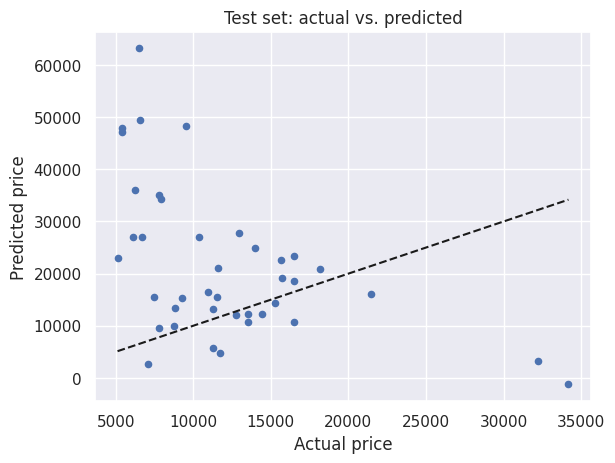

In [21]:
# YOUR CODE HERE

train_mse = model_tf.evaluate(X_train_std, Y_train_std, verbose=0)

test_mse  = model_tf.evaluate(X_test_std,  Y_test_std,  verbose=0)

print(train_mse)
print(test_mse)

'''Yes, the model demonstrates strong generalization capabilites, due to train and test MSE have a slight difference'''

y_pred_std = model_tf.predict(X_test_std).flatten()

##back to original scale
y_pred = y_pred_std * sig_y + mu_y
y_true = Y_test_std * sig_y + mu_y

#plotting
plt.scatter(y_true, y_pred, s=20)
plt.plot([y_true.min(), y_true.max()],[y_true.min(), y_true.max()], 'k--')
plt.xlabel("Actual price");  plt.ylabel("Predicted price")
plt.title("Test set: actual vs. predicted")
plt.show()

'''there isn't a clear relationship seen in the plot between the actual and predicted values'''

----
### <span style="color:chocolate"></span> Additional practice (not graded)

In Exercise 12, you reported an aggregated MSE. Let's revisit the exercise by:

1. Performing a subgroup evaluation of the model. Specifically, calculate the test data MSE for the following makes: ['alfa-romero', 'audi', 'chevrolet', 'dodge', 'honda'].
2. Addressing the question: Is the model "fair" across each make?

In [ ]:
# YOUR CODE HERE